# Vaccines and patient characteristics

## Import libraries and data

The datasets used for this report are created using the study definition [`/analysis/study_definition.py`](../analysis/study_definition.py), using codelists referenced in [`/codelists/codelists.txt`](../codelists/codelists.txt). 

In [1]:
%load_ext autoreload
%autoreload 2

import pyodbc
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date
import os
import glob
import subprocess
from ebmdatalab import charts
from IPython.display import display, Markdown, HTML
import json
#from lib.functions import *
# export incidence-only data for downloading

# create /assign directories for exporting figures and tables
savepath = {}
for filetype in ["tables", "figures", "text"]:
    savepath[filetype] = os.path.abspath(os.path.join("..", "interim-outputs", filetype))
    if not os.path.exists(savepath[filetype]):
        os.makedirs(savepath[filetype])

# create /assign directories for exporting csvs behind the figures & for tables
savepath_figure_csvs = os.path.abspath(os.path.join("..", "machine_readable_outputs", "figure_csvs"))
if not os.path.exists(savepath_figure_csvs):
    os.makedirs(savepath_figure_csvs)
savepath_table_csvs = os.path.abspath(os.path.join("..", "machine_readable_outputs", "table_csvs"))
if not os.path.exists(savepath_table_csvs):
    os.makedirs(savepath_table_csvs)

# get current branch
current_branch = subprocess.run(["git", "rev-parse", "--abbrev-ref", "HEAD"], capture_output=True).stdout.decode("utf8").strip()

In [2]:
# import data, carry out basic joins for lookups and create flags.

# import data and fill nulls with 0
df = pd.read_csv(os.path.join("..","output", "input_delivery.csv")).fillna(0)

# ensure that no patients are included outside the desired criteria
# df = df.loc[(df["care_home_type"].isin(["PS","PN","PC"])) | (df["ageband"].isin(["70-79","80+"]) | (df["covid_vacc_date"]!=0)]
 
# convert ethnic categories to words
eth_16 = pd.read_csv(os.path.join("..","analysis", "ethnicity_16_lookup.csv"))
df = df.merge(eth_16, how="left", left_on="ethnicity_16", right_on="code").rename(columns={"name":"Ethnicity_sixteen_categories"})

ethnicity_6_lookup = {0:"Unknown", 1:"White", 2:"Mixed", 3:"South Asian", 4:"Black", 5:"Other"}
df["Ethnicity_broad_categories"] = [ethnicity_6_lookup[x] for x in df['ethnicity'].fillna(0).astype(int)]

# describe imd partially in words
imd_lookup = {0:"Unknown", 1:"1 Most deprived", 2:"2", 3:"3", 4:"4", 5:"5 Least deprived"}

# replace flags with descriptive terms
df = df.assign(
    covid_vacc_flag = np.where(df["covid_vacc_date"]!=0,"vaccinated","unvaccinated"),
    covid_vacc_flag_ox = np.where(df["covid_vacc_oxford_date"]!=0, 1, 0),
    covid_vacc_flag_pfz = np.where(df["covid_vacc_pfizer_date"]!=0, 1, 0),
    covid_vacc_2nd = np.where(df["covid_vacc_second_dose_date"]!=0, 1, 0),
    covid_vacc_bin = np.where(df["covid_vacc_date"]!=0, 1, 0),
    ##care_home = np.where(df["care_home_type"].isin(["PS","PN","PC"]), "care home", "other residences"),
    ssri = np.where((df["ssri"]==1) & (df["psychosis_schiz_bipolar"]==0) &\
                    (df["intel_dis_incl_downs_syndrome"]==0) & (df["dementia"]==0), 1, 0),
    Ethnicity_broad_categories = df['Ethnicity_broad_categories'].fillna("Unknown"),
    Ethnicity_sixteen_categories = df['Ethnicity_sixteen_categories'].fillna("Unknown"),
    region = df['region'].replace(0, "Unknown"),
    stp = df['stp'].replace(0, "Unknown"),
    sex = df['sex'].replace(['I','U'], "Other/Unknown"),
    bmi = np.where((df["bmi"]=="Not obese"), "under 30", "30+"),
    Index_of_Multiple_Deprivation = [imd_lookup[x] for x in df['imd'].fillna(0).astype(int)]
    )\
    .drop(["imd","code","ethnicity_16", "ethnicity", "adrenaline_pen", "has_died", "has_follow_up"],1)

# care homes: regroup age bands (to later keep only 65+ labelled as care home residents)
df.loc[(df["care_home_type"].isin(["PS","PN","PC"])) & (df["age"]>=65) & (df["age"]<70), "ageband"] = "65-69"
# amend community age band to remove any care home flags for under 65s 
    #(only elderly care homes are included so these are likely live-in staff+their families or other non-care recipients)
df.loc[(df["ageband_community"]=="care home") & (df["age"]<65), "ageband_community"] = df["ageband"]
    
for c in ["care_home","dementia", 
          "chronic_cardiac_disease", "current_copd", "dialysis", "dmards","psychosis_schiz_bipolar",
         "solid_organ_transplantation", "chemo_or_radio", "intel_dis_incl_downs_syndrome","ssri",
          "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer", "bone_marrow_transplant",
          "cystic_fibrosis", "sickle_cell_disease", "permanant_immunosuppression",
          "temporary_immunosuppression", "asplenia"]:
    df[c] = np.where(df[c]==1, "yes", "no")
   
df = df.rename(columns={"imd":"Index_of_Multiple_Deprivation", "ageband_community":"community_ageband"})
# get total population sizes and names for each STP
stps = pd.read_csv(os.path.join("..","lib","stp_dict.csv"), usecols=["stp_id","name","list_size_o80"])
df = df.merge(stps, left_on="stp", right_on="stp_id", how="left").drop(["care_home_type","age","stp_id"], 1).rename(columns={"name":"stp_name"})  
    

In [3]:
# Find latest date of covid vaccinations covered in the dataset   

latest_date = df[df["covid_vacc_date"]!=0]["covid_vacc_date"].max()
latest_date_fmt = datetime.strptime(latest_date, "%Y-%m-%d").strftime("%d %b %Y")
print("latest date ", latest_date_fmt)
with open(os.path.join(savepath["text"], "latest_date.txt"), "w") as text_file:
    text_file.write(latest_date_fmt)

latest date  31 Jan 2021


## Process data - summarise by group and demographics at latest date

#### Calculate cumulative sums at each date and select latest date + previous figures for comparison

In [4]:
# population subgroups - in a dict to indicate which field to filter on
pops = {"80+":"community_ageband",
        "70-79":"community_ageband", 
        "care home":"community_ageband", 
        "under 70s, not resident in care homes":"other"
        }
groups = pops.keys()

def cumsums(df, groups):
    '''
    Calculate cumulative sums
    
    Inputs:
    df (dataframe): input data
    groups(list): subgroups to breakdown by
    
    out: 
    out2(dataframe)
    '''
    df_dict_out = {}
    for k in groups:
        # filter dataframe to eligible group
        if pops[k]=="other": # for "all others" filter out the defined groups above
            out = df.copy().loc[(~df["community_ageband"].isin(["care home","70-79","80+"]))]
            cols = ["sex","ageband", "Ethnicity_broad_categories", "Ethnicity_sixteen_categories","Index_of_Multiple_Deprivation",
                    "bmi","chronic_cardiac_disease", "current_copd", "dialysis", "dmards","ssri"]
        elif k=="care home": 
            out = df.copy().loc[(df[pops[k]]==k)]
            cols = ["sex", "ageband", "Ethnicity_broad_categories"]
        else:    # age groups
            out = df.copy().loc[(df[pops[k]]==k)]
            cols = ["sex","Ethnicity_broad_categories","Ethnicity_sixteen_categories", "Index_of_Multiple_Deprivation", 
                    "bmi", "chronic_cardiac_disease", "current_copd", "dialysis", "dmards", "dementia",
                    "psychosis_schiz_bipolar","intel_dis_incl_downs_syndrome","ssri",
                     "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"]
            
        df_dict_temp = {}
        
        # overall figures
        total = out[["patient_id"]].nunique()[0]
        out2 = out.copy().loc[(out["covid_vacc_flag"]=="vaccinated")]
        # group by date of covid vaccines to calculate cumulative sum of vaccines at each date of the campaign
        out2 = pd.DataFrame(out2.groupby(["covid_vacc_date"])[["patient_id"]].nunique().unstack().fillna(0).cumsum()).reset_index()
        out2 = out2.rename(columns={0:"overall"}).drop(["level_0"],1)

        # in case no vaccinations on latest date for some STPs/groups, insert the latest data as a new row with the required date:
        if out2["covid_vacc_date"].max()<latest_date:
            out2.loc[max(out2.index)+1] = [latest_date, out2["overall"].max()]

        # suppress low numbers
        out2["overall"] = out2["overall"].replace([1,2,3,4,5,6], 0).fillna(0).astype(int)
        out2["overall_total"] = total.astype(int)
        
        out2["overall_percent"] = 100*(out2["overall"]/out2["overall_total"])
        df_dict_temp["overall"] = out2.set_index("covid_vacc_date")
        
        # figures by demographic/clinical features
        for c in cols:
            
            if c=="sex":
                out = out.loc[out[c].isin(["M","F"])]

            # find total number of patients in each subgroup (e.g. no of males and no of females)
            totals = out.groupby([c])[["patient_id"]].nunique().rename(columns={"patient_id":"total"}).transpose()
            
            # find total number of patients vaccinated in each subgroup (e.g. no of males and no of females),
                # cumulative at each date of the campaign
            out2 = out.copy().loc[(out["covid_vacc_flag"]=="vaccinated")]
            out2 = out2.groupby([c, "covid_vacc_date"])["patient_id"].nunique().unstack(0)
            out2 = out2.fillna(0).cumsum()
            
            # suppress low numbers
            out2 = out2.replace([1,2,3,4,5,6], 0).fillna(0)
            # round other values to nearest 7
            out2 = 7*round(out2/7, 0)

            for c2 in out2.columns:
                out2[f"{c2}_total"] = totals[c2][0].astype(int)
                #calculate percentage
                out2[f"{c2}_percent"] = 100*(out2[c2]/out2[f"{c2}_total"])           
            
            # in case no vaccinations on latest date for some STPs/groups, insert the latest data as a new row with the required date:
            if out2.index.max()<latest_date:
                out2.loc[latest_date] = out2.max()
                
            df_dict_temp[c] = out2
        
        df_dict_out[k] = df_dict_temp

    return df_dict_out
    

df_dict_cum = cumsums(df, groups) 


In [5]:
def report_results(df_dict_cum, group, breakdown=[]):
    '''
    Summarise data at latest date, overall and by demographic/clinical features, and including change from previous week.
    Processes one group (e.g. 80+) at a time so must be run within a loop to cover all required groups. 
    
    Inputs:
    df_dict_cum (dict): dictionary of cumulative sums 
    group (str): e.g. "80+" (one of first level index of df_dict_cum)
    breakdown (list): 
    
    Outputs:
    out3 (Dataframe): summary data
    '''
    
    out = pd.DataFrame()
    out3 = pd.DataFrame()
    
    k=group
    
    if len(breakdown)== 0:
        breakdown = df_dict_cum[k].keys()
    
    for c in breakdown:
        out = df_dict_cum[k][c]

        # calculate changes: select only latest date and 7 days ago:
        latest = pd.to_datetime(out.index).max()
        lastweek = (latest + pd.DateOffset(days=-7)).strftime("%Y-%m-%d")
        lastweek = str(max(lastweek, out.index.min()))

        # filter to required values:

        # for groups with a population denominator, keep the percentage value only
        if k != "under 70s, not resident in care homes":
            out = out.filter(regex='percent').round(1)
            col_str = " (percent)"
        # for groups with no denominator, keep the actual values only
        elif k == "under 70s, not resident in care homes":
            # totals and percent not needed
            out = out.filter(regex='^(?!.*total).*$')
            out = out.filter(regex='^(?!.*percent).*$')
            col_str = ""
        
        # if last week's exact date not present, fill in using latest values prior to required date
        if sum(out.index == lastweek)==0:
            out.loc[lastweek] = out.loc[out.index < lastweek].max()
            
        out = out.loc[[latest_date,lastweek],:].transpose()

        '''# if there is only one non-zero value, round the remaining values to avoid suppressed values being calculated
            for i in out2.index:
                if (out2.loc[i] == 0).astype(int).sum() == 1:  
                    out2.loc[i]=10*(out2.loc[i]/10).round(0)
            display(out2)'''
        
        out["weeklyrate"] = ((out[latest_date] - out[lastweek]).fillna(0)).round(1)
        out["Increase in uptake (%)"] = (100*(out["weeklyrate"]/out[lastweek]).fillna(0)).round(1)
        out["weeks_to_target"] = (90 - out[latest_date])/out["weeklyrate"]

        date_reached=pd.Series(dtype="datetime64[ns]", name="date_reached")

        for i in out.index:
            weeks_to_target = out["weeks_to_target"][i]
            if weeks_to_target <=0: #already reached target
                date_reached[i] = "reached"
            if weeks_to_target <25: # if 6mo+ until expected to reach target, assume too little data to tell
                date_reached[i] = (latest + pd.DateOffset(days=weeks_to_target*7)).strftime('%d-%b')
            else:
                date_reached[i] = "unknown"
        out = out.transpose().append(date_reached).transpose().drop("weeks_to_target",1)
        out = out[[lastweek,"weeklyrate","date_reached","Increase in uptake (%)"]].rename(columns={lastweek: f"vaccinated 7d previous {col_str}", "weeklyrate":f"Uptake over last 7d{col_str}", "date_reached":"Date projected to reach 90%"})    
        out.index = out.index.str.replace("_percent","")    
        out = out.reset_index().rename(columns={c:"group", "index":"group"})
        out["category"] = c
        out = out.set_index(["category","group"])


        ##### n, percent and total pop figures for latest date
        out2 = df_dict_cum[k][c].reset_index()
        out2 = out2.loc[out2["covid_vacc_date"]==latest_date].reset_index().set_index("covid_vacc_date").drop(["index"], 1).transpose()
        # split field names e.g. "M_percent" ->"M""percent"
        out2.index = pd.MultiIndex.from_tuples(out2.index.str.split('_').tolist())

        out2 = out2.unstack().reset_index(col_level=1)
        out2.columns = out2.columns.droplevel()
        out2 = out2.rename(columns={"index":"group", np.nan:"vaccinated"})
        out2["percent"] = out2["percent"].round(1)
        out2["category"] = c
        out2 = out2.set_index(["category","group"])

        out2 = out2.join(out)

        out3 = out3.append(out2)   

    if k == "under 70s, not resident in care homes":
        out3 = out3.drop(["percent","total","Date projected to reach 90%"],1)
    else:
        out3 = out3.drop(["Increase in uptake (%)"],1)
    
    return out3

## Cumulative vaccination figures - overall

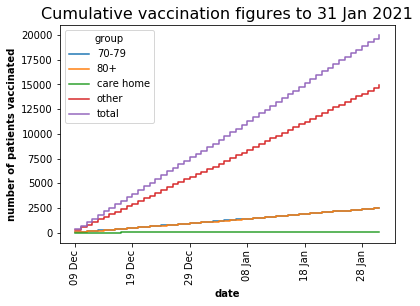

In [6]:
# cumulative chart by day of total vaccines given
dfp = df.copy().loc[(df["covid_vacc_date"]!=0)]
dfp["group"] = np.where(dfp["community_ageband"].isin(["80+","70-79","care home"]), dfp["community_ageband"], "other")
dfp = dfp.groupby(["covid_vacc_date","group"])[["patient_id"]].count()  
dfp = dfp.unstack().fillna(0).cumsum().reset_index().replace([0,1,2,3,4,5],0) 

dfp["covid_vacc_date"] = pd.to_datetime(dfp["covid_vacc_date"]).dt.strftime("%d %b")
dfp = dfp.set_index("covid_vacc_date")
dfp.columns = dfp.columns.droplevel()
dfp["total"] = dfp.sum(axis=1)

dfp.plot(legend=True, ds='steps-post')

plt.xlabel("date", fontweight='bold')
plt.xticks(rotation=90)
plt.ylabel("number of patients vaccinated", fontweight='bold')
plt.title(f"Cumulative vaccination figures to {latest_date_fmt}", fontsize=16)
plt.savefig(os.path.join(savepath["figures"], f"Cumulative vaccination figures.svg"), dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# summarise data at latest date
groups = ["80+", "70-79", "care home", "under 70s, not resident in care homes"]
df_dict_latest = {}
for g in groups:
    out = report_results(df_dict_cum, g)
    df_dict_latest[g] = out

## Proportion of each eligible population vaccinated to date

In [8]:
#display(Markdown(f"### As at {latest_date_fmt}"))

# create a dict to store results for display and for exporting to a txt file
summary_stats= {}
summary_stats[f"### As at {latest_date_fmt}"] = ""


def round7(n):
    '''Round n to nearest 7 and output as integer'''
    return ( int(7*round((n/7),1)) )

vaccinated_total = round7( df.loc[df["covid_vacc_date"]!=0]["patient_id"].nunique() )
summary_stats["**Total** population vaccinated in TPP"] = f"{vaccinated_total:,d}"
latest_rate = {}

for k in groups:
    out = df_dict_latest[k]
    vaccinated = round7(out.loc[("overall","overall")]["vaccinated"])
    if k != "under 70s, not resident in care homes":
        percent = out.loc[("overall","overall")]["percent"].round(1)
        total = out.loc[("overall","overall")]["total"].astype(int)
        summary_stats[f"**{k}** population vaccinated"] = f"{vaccinated:,} ({percent}% of {total:,})"
        #out_str = f"**{k}** population vaccinated {vaccinated:,} ({percent}% of {total:,})"
    else:
        #out_str = f"**{k}** population vaccinated {vaccinated:,}"
        summary_stats[f"**{k}** population vaccinated"] = f"{vaccinated:,}"

    latest_rate[k] = percent # store values for later use


    #display(Markdown(out_str))

# count oxford vax as a proportion of total; filter to date of first vax only in case of patients having mixed types    
oxford_vaccines = round7(df.copy().loc[df["covid_vacc_date"]==df["covid_vacc_oxford_date"]]["covid_vacc_flag_ox"].sum())
ox_percent = round(100*oxford_vaccines/vaccinated_total, 1)
second_doses = round7(df["covid_vacc_2nd"].sum())
sd_percent = round(100*second_doses/vaccinated_total, 1)

summary_stats[f"#### Vaccine types and second doses"] = ""
summary_stats["Second doses (% of all vaccinated)"] = f"{second_doses:,} ({sd_percent}%)"
summary_stats["Oxford-AZ vaccines (% of all first doses)"] = f"{oxford_vaccines:,} ({ox_percent}%)"

# export summary stats to text file
json.dump(summary_stats, open(os.path.join(savepath["text"], "summary_stats.txt"),'w'))

for x in summary_stats.keys():
    display(Markdown(f"{x}: {summary_stats[x]}"))
    
display(Markdown("#### \n figures rounded to nearest 7"))


### As at 31 Jan 2021: 

**Total** population vaccinated in TPP: 19,999

**80+** population vaccinated: 2,489 (38.6% of 6,456)

**70-79** population vaccinated: 2,517 (39.9% of 6,308)

**care home** population vaccinated: 100 (44.9% of 225)

**under 70s, not resident in care homes** population vaccinated: 14,891

#### Vaccine types and second doses: 

Second doses (% of all vaccinated): 15,000 (75.0%)

Oxford-AZ vaccines (% of all first doses): 2 (0.0%)

#### 
 figures rounded to nearest 7

# Detailed summary of uptake among population groups as at latest date

In [9]:
pd.set_option('display.max_rows',200)

for g in groups:
    display(Markdown(f"## "),
            Markdown(f"## COVID vaccination rollout among **{g}** population up to {latest_date_fmt}"),
            Markdown(f"- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)\n"\
                       f"- Patient counts rounded to the nearest 7"))
    out = df_dict_latest[g]

    display(out)
    out_csv = out.copy()
    if "Date projected to reach 90%" in out.columns:
        out_csv = out_csv.drop("Date projected to reach 90%",1)
        
    # export for presentation in tidy report version
    out_csv.to_csv(os.path.join(savepath["tables"], f"Cumulative vaccination figures among {g} population.csv"), index=True)

## 

## COVID vaccination rollout among **80+** population up to 31 Jan 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                      group                                             
overall                       overall                                  2489.0   
sex                           F                                        1302.0   
                              M                                        1183.0   
Ethnicity_broad_categories    Black                                     364.0   
                              Mixed                                     350.0   
                              Other                                     406.0   
                              South Asian                               378.0   
                              Unknown                                   595.0   
                              White                                     392.0   
Ethnicity_sixteen_categories   African                                  105.0   
                               Bangladeshi or British Bangladeshi       112.0   
                               Caribbean                                119.0   
                               Chinese                                  126.0   
                               Other                                    105.0   
                               Other Asian                              126.0   
                              British or Mixed British                  119.0   
                              Indian or British Indian                  119.0   
                              Irish                                      98.0   
                              Other Black                                98.0   
                              Other White                               112.0   
                              Other mixed                               133.0   
                              Pakistani or British Pakistani            126.0   
                              Unknown                                   651.0   
                              White + Asian                             112.0   
                              White + Black African                     112.0   
                              White + Black Caribbean                   112.0   
Index_of_Multiple_Deprivation 1 Most deprived                           497.0   
                              2                                         448.0   
                              3                                         455.0   
                              4                                         504.0   
                              5 Least deprived                          476.0   
                              Unknown                                   105.0   
bmi                           30+                                       791.0   
                              under 30                                 1701.0   
chronic_cardiac_disease       no                                       2464.0   
                              yes                                        21.0   
current_copd                  no                                       2450.0   
                              yes                                        35.0   
dialysis                      no                                       2464.0   
                              yes                                        21.0   
dmards                        no                                       2464.0   
                              yes                                        28.0   
dementia                      no                                       2464.0   
                              yes                                        28.0   
psychosis_schiz_bipolar       no                                       2471.0   
                              yes                                        21.0   
intel_dis_incl_downs_syndrome no                                       2471.0   
                              yes                                        21.0   
ssri             

## 

## COVID vaccination rollout among **70-79** population up to 31 Jan 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                      group                                             
overall                       overall                                  2518.0   
sex                           F                                        1302.0   
                              M                                        1211.0   
Ethnicity_broad_categories    Black                                     413.0   
                              Mixed                                     378.0   
                              Other                                     364.0   
                              South Asian                               378.0   
                              Unknown                                   588.0   
                              White                                     392.0   
Ethnicity_sixteen_categories   African                                  126.0   
                               Bangladeshi or British Bangladeshi       119.0   
                               Caribbean                                112.0   
                               Chinese                                  105.0   
                               Other                                    126.0   
                               Other Asian                              119.0   
                              British or Mixed British                  119.0   
                              Indian or British Indian                  126.0   
                              Irish                                     133.0   
                              Other Black                               112.0   
                              Other White                               112.0   
                              Other mixed                               140.0   
                              Pakistani or British Pakistani            112.0   
                              Unknown                                   630.0   
                              White + Asian                             126.0   
                              White + Black African                     105.0   
                              White + Black Caribbean                   105.0   
Index_of_Multiple_Deprivation 1 Most deprived                           490.0   
                              2                                         483.0   
                              3                                         455.0   
                              4                                         462.0   
                              5 Least deprived                          497.0   
                              Unknown                                   133.0   
bmi                           30+                                       791.0   
                              under 30                                 1729.0   
chronic_cardiac_disease       no                                       2492.0   
                              yes                                        28.0   
current_copd                  no                                       2485.0   
                              yes                                        35.0   
dialysis                      no                                       2485.0   
                              yes                                        35.0   
dmards                        no                                       2485.0   
                              yes                                        28.0   
dementia                      no                                       2499.0   
                              yes                                        21.0   
psychosis_schiz_bipolar       no                                       2499.0   
                              yes                                        21.0   
intel_dis_incl_downs_syndrome no                                       2485.0   
                              yes                                        28.0   
ssri             

## 

## COVID vaccination rollout among **care home** population up to 31 Jan 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                   group                                     
overall                    overall           101.0     44.9  225.0   
sex                        F                  56.0     43.8  128.0   
                           M                  42.0     43.3   97.0   
ageband                    0-19               14.0     51.9   27.0   
                           20-29              14.0     51.9   27.0   
                           30-39               7.0     28.0   25.0   
                           40-49              14.0     41.2   34.0   
                           50-59               7.0     24.1   29.0   
                           60-69               7.0     30.4   23.0   
                           65-69               0.0      0.0   12.0   
                           70-79              14.0     48.3   29.0   
                           80+                14.0     73.7   19.0   
Ethnicity_broad_categories Black              14.0     48.3   29.0   
                           Mixed              14.0     35.9   39.0   
                           Other              14.0     43.8   32.0   
                           South Asian        14.0     41.2   34.0   
                           Unknown            21.0     38.9   54.0   
                           White              14.0     37.8   37.0   

                                       vaccinated 7d previous  (percent)  \
category                   group                                           
overall                    overall                                  41.3   
sex                        F                                        43.8   
                           M                                        43.3   
ageband                    0-19                                     51.9   
                           20-29                                    51.9   
                           30-39                                      28   
                           40-49                                    41.2   
                           50-59                                    24.1   
                           60-69                                    30.4   
                           65-69                                       0   
                           70-79                                    48.3   
                           80+                                      73.7   
Ethnicity_broad_categories Black                                    48.3   
                           Mixed                                    35.9   
                           Other                                    43.8   
                           South Asian                              41.2   
                           Unknown                                  38.9   
                           White                                    37.8   

                                       Uptake over last 7d (percent)  \
category                   group                                       
overall                    overall                               3.6   
sex                        F                                       0   
                           M                                       0   
ageband                    0-19                                    0   
                           20-29                                   0   
                           30-39                                   0   
                           40-49                                   0   
                           50-59                                   0   
                           60-69                                   0   
                           65-69                                   0   
                           70-79                                   0   
                           80+                                     0   
Ethnicity_broad_categories Black                                   0   
                           Mixed      

## 

## COVID vaccination rollout among **under 70s, not resident in care homes** population up to 31 Jan 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                      group                                             
overall                       overall                                 14892.0   
sex                           F                                        7742.0   
                              M                                        7154.0   
ageband                       0-19                                     1827.0   
                              20-29                                    1890.0   
                              30-39                                    1820.0   
                              40-49                                    1834.0   
                              50-59                                    1890.0   
                              60-69                                    1918.0   
                              65-69                                     126.0   
                              70-79                                    1785.0   
                              80+                                      1806.0   
Ethnicity_broad_categories    Black                                    2226.0   
                              Mixed                                    2240.0   
                              Other                                    2247.0   
                              South Asian                              2212.0   
                              Unknown                                  3738.0   
                              White                                    2233.0   
Ethnicity_sixteen_categories   African                                  707.0   
                               Bangladeshi or British Bangladeshi       707.0   
                               Caribbean                                679.0   
                               Chinese                                  728.0   
                               Other                                    728.0   
                               Other Asian                              707.0   
                              British or Mixed British                  686.0   
                              Indian or British Indian                  721.0   
                              Irish                                     693.0   
                              Other Black                               658.0   
                              Other White                               735.0   
                              Other mixed                               735.0   
                              Pakistani or British Pakistani            693.0   
                              Unknown                                  3640.0   
                              White + Asian                             665.0   
                              White + Black African                     693.0   
                              White + Black Caribbean                   721.0   
Index_of_Multiple_Deprivation 1 Most deprived                          2786.0   
                              2                                        2800.0   
                              3                                        2863.0   
                              4                                        2849.0   
                              5 Least deprived                         2821.0   
                              Unknown                                   770.0   
bmi                           30+                                      4361.0   
                              under 30                                10528.0   
chronic_cardiac_disease       no                                      14721.0   
                              yes                                       175.0   
current_copd                  no                                      14749.0   
                              yes                                       140.0   
dialysis                      no                                      14763.0   
                 

# Demographics time trend charts

## 
 ## COVID vaccination rollout among **80+** population up to 31 Jan 2021

### COVID vaccinations among **80+** population by **sex**

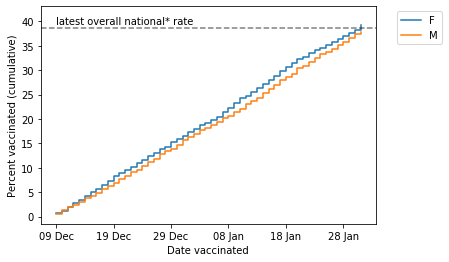

### COVID vaccinations among **80+** population by **Ethnicity broad categories**

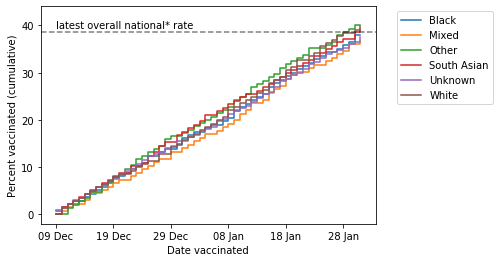

### COVID vaccinations among **80+** population by **Index of Multiple Deprivation**

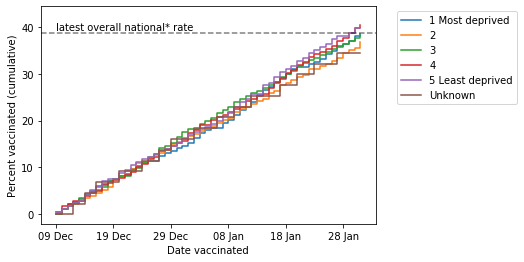

### COVID vaccinations among **80+** population by **bmi**

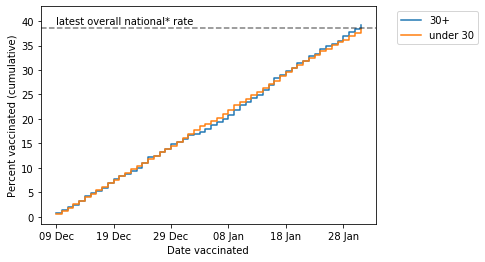

### COVID vaccinations among **80+** population by **chronic cardiac disease**

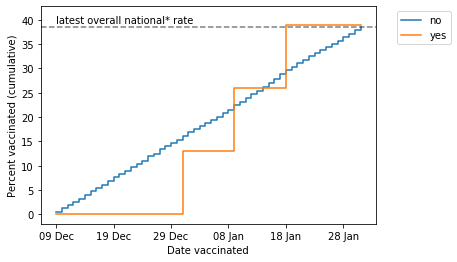

### COVID vaccinations among **80+** population by **current copd**

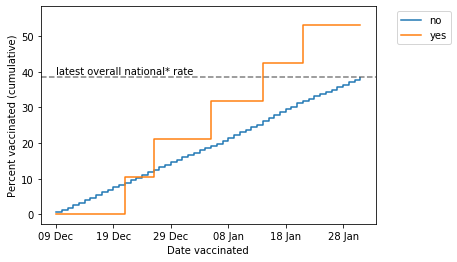

### COVID vaccinations among **80+** population by **dialysis**

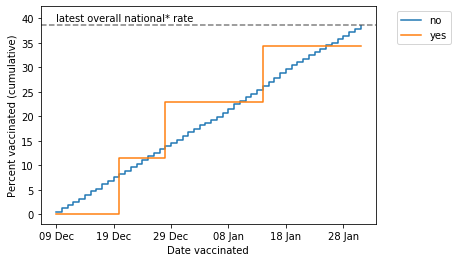

### COVID vaccinations among **80+** population by **dmards**

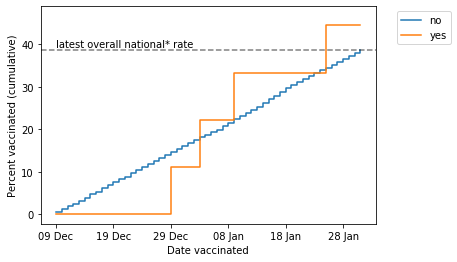

### COVID vaccinations among **80+** population by **psychosis schiz bipolar**

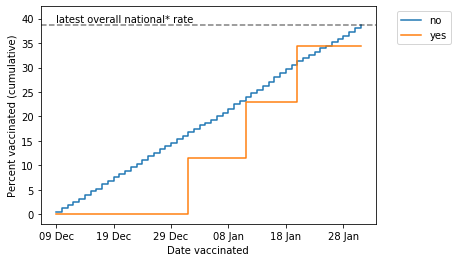

### COVID vaccinations among **80+** population by **intel dis incl downs syndrome**

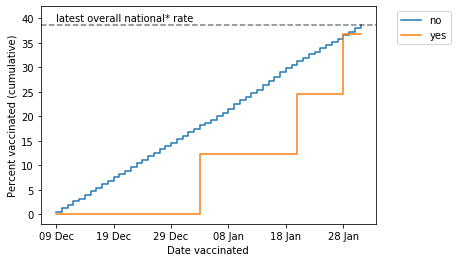

### COVID vaccinations among **80+** population by **dementia**

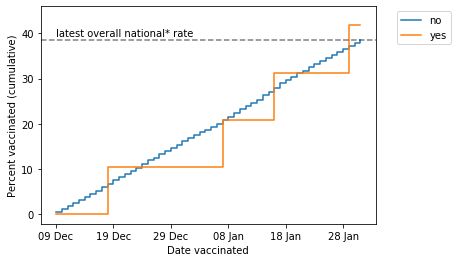

### COVID vaccinations among **80+** population by **ssri**

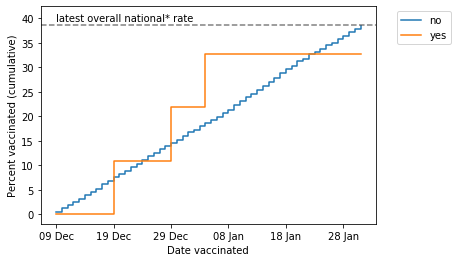

### COVID vaccinations among **80+** population by **chemo or radio**

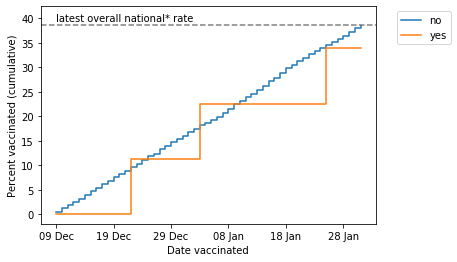

### COVID vaccinations among **80+** population by **lung cancer**

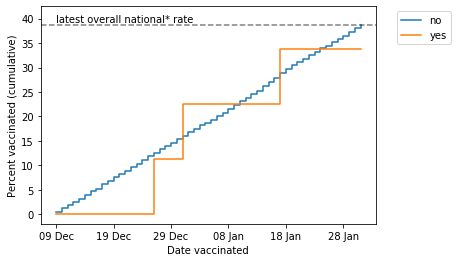

### COVID vaccinations among **80+** population by **cancer excl lung and haem**

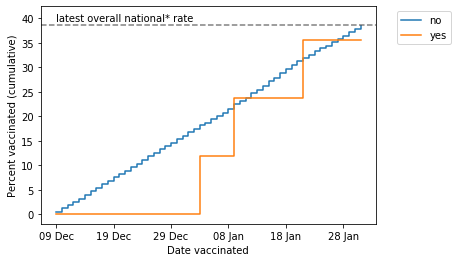

### COVID vaccinations among **80+** population by **haematological cancer**

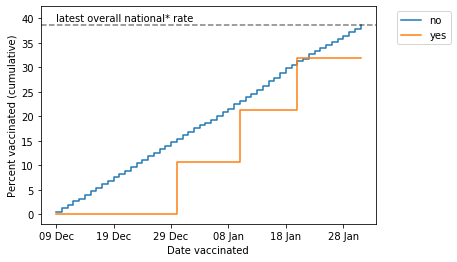

## 
 ## COVID vaccination rollout among **70-79** population up to 31 Jan 2021

### COVID vaccinations among **70-79** population by **sex**

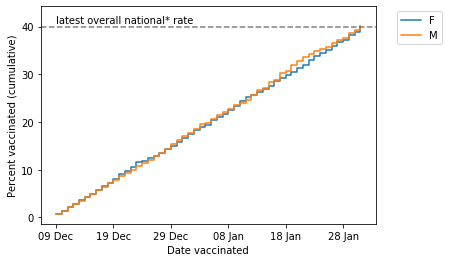

### COVID vaccinations among **70-79** population by **Ethnicity broad categories**

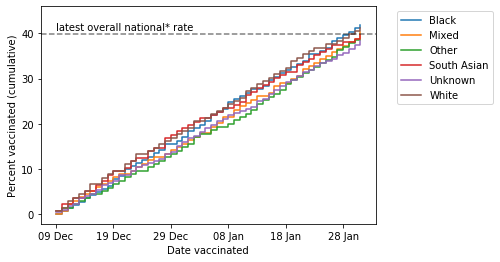

### COVID vaccinations among **70-79** population by **Index of Multiple Deprivation**

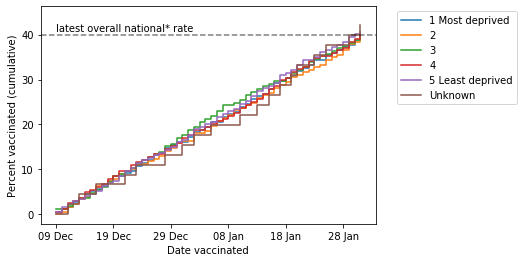

### COVID vaccinations among **70-79** population by **bmi**

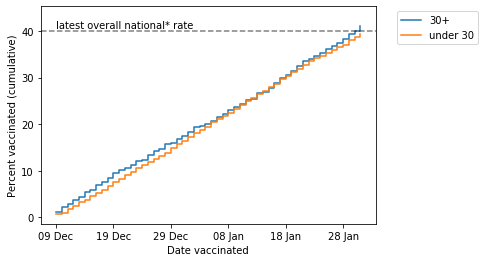

### COVID vaccinations among **70-79** population by **chronic cardiac disease**

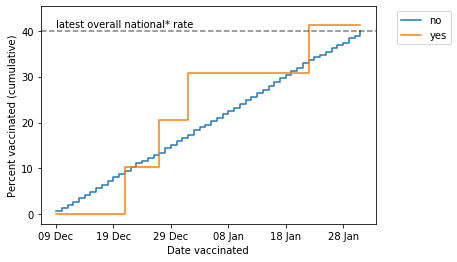

### COVID vaccinations among **70-79** population by **current copd**

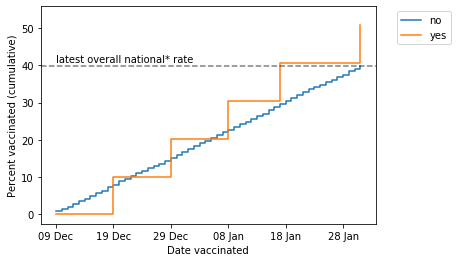

### COVID vaccinations among **70-79** population by **dialysis**

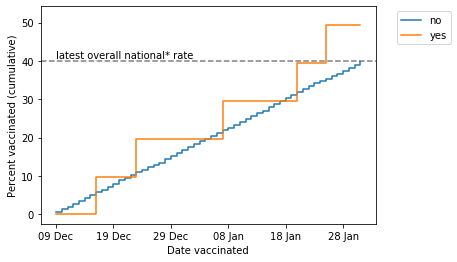

### COVID vaccinations among **70-79** population by **dmards**

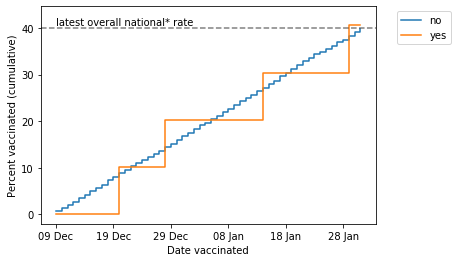

### COVID vaccinations among **70-79** population by **psychosis schiz bipolar**

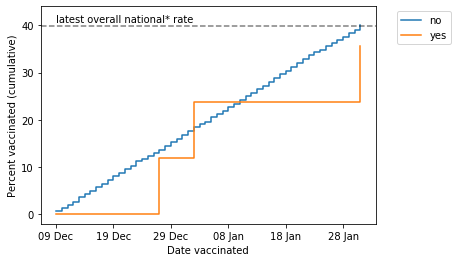

### COVID vaccinations among **70-79** population by **intel dis incl downs syndrome**

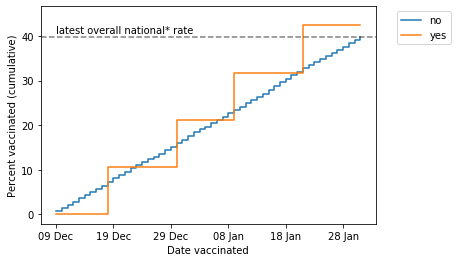

### COVID vaccinations among **70-79** population by **dementia**

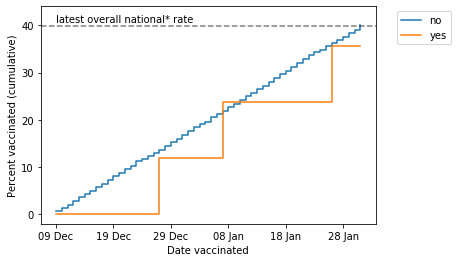

### COVID vaccinations among **70-79** population by **ssri**

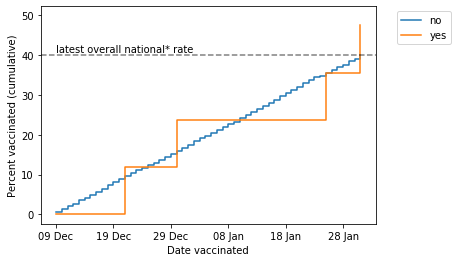

### COVID vaccinations among **70-79** population by **chemo or radio**

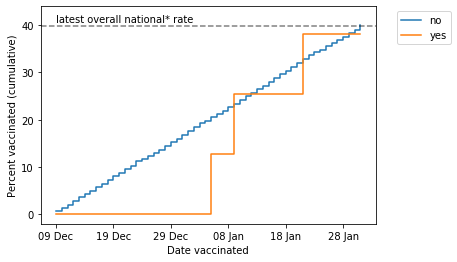

### COVID vaccinations among **70-79** population by **lung cancer**

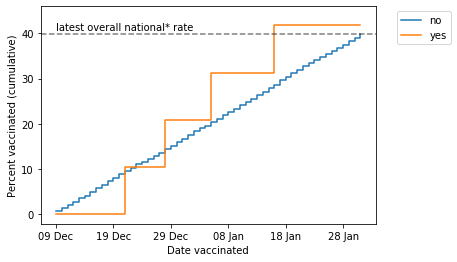

### COVID vaccinations among **70-79** population by **cancer excl lung and haem**

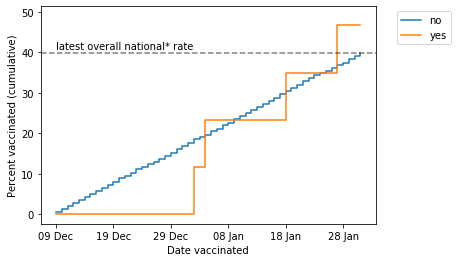

### COVID vaccinations among **70-79** population by **haematological cancer**

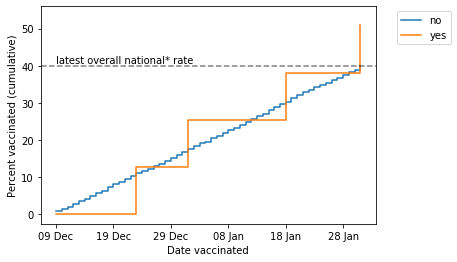

In [10]:
def plot_dem_charts(df_dict, include_overall=False):
    if include_overall==False:
        groups = ["sex","Ethnicity_broad_categories","Index_of_Multiple_Deprivation", "bmi", "chronic_cardiac_disease", "current_copd", "dialysis", "dmards",
                    "psychosis_schiz_bipolar","intel_dis_incl_downs_syndrome","dementia", "ssri",
                     "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"]
    else:
        groups = ["overall","sex","Ethnicity_broad_categories","Index_of_Multiple_Deprivation", "bmi", "chronic_cardiac_disease", "current_copd", "dialysis", "dmards",
                    "psychosis_schiz_bipolar","intel_dis_incl_downs_syndrome","dementia", "ssri",
                     "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"]
   
    for k in ["80+", "70-79"]:
        display(Markdown(f"## \n ## COVID vaccination rollout among **{k}** population up to {latest_date_fmt}"))

        out=df_dict[k]
        for c in groups:
            out=df_dict[k][c]
            # suppress low numbers         
            cols = out.columns[(~out.columns.str.contains("_percent")) & (~out.columns.str.contains("_total"))]
            for c2 in cols:
                #  drop vaccinated and total column but keep percentage
                out = out.drop([c2, f"{c2}_total"],1)
                out = out.rename(columns={f"{c2}_percent":c2})

            display(Markdown(f"### COVID vaccinations among **{k}** population by **{c.replace('_',' ')}**"))
            out = out.reset_index()
            out["covid_vacc_date"] = pd.to_datetime(out["covid_vacc_date"]).dt.strftime("%d %b")
            out = out.set_index("covid_vacc_date")
            out.round(2).to_csv(os.path.join(savepath_figure_csvs, f"Cumulative vaccination percent among {k} population by {c.replace('_',' ')}.csv"), index=True)

            out.plot(legend=True, ds='steps-post')
            plt.axhline(latest_rate[k], color="k", linestyle="--", alpha=0.5)
            plt.text(0, latest_rate[k]*1.02, "latest overall national* rate")
            plt.ylim(top=1.1*max(latest_rate[k], out.max().max()))
            plt.ylabel("Percent vaccinated (cumulative)")
            plt.xlabel("Date vaccinated")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.savefig(os.path.join(savepath["figures"], f"COVID vaccinations among {k} population by {c.replace('_',' ')}.svg"), dpi=300, bbox_inches='tight')

            plt.show()
            
plot_dem_charts(df_dict_cum)

## Completeness of ethnicity recording

In [11]:
# overall among vaccinated people
vaccinated = df[["covid_vacc_date","community_ageband","Ethnicity_broad_categories","patient_id"]].loc[df["covid_vacc_date"]!=0]
vaccinated_ethnicity = vaccinated.groupby("Ethnicity_broad_categories")[["patient_id"]].nunique().reset_index()
out = vaccinated_ethnicity.loc[vaccinated_ethnicity["Ethnicity_broad_categories"]!="Unknown"]["patient_id"].sum()/\
    vaccinated_ethnicity["patient_id"].sum()

# in subgroups with denominators
for k in ["80+", "70-79","care home"]:
    out = df[["community_ageband","Ethnicity_broad_categories","patient_id","care_home"]].copy()
    out = out.loc[out[pops[k]]==k]
    
    total = out["patient_id"].nunique()
    
    known_eth = out.groupby("Ethnicity_broad_categories")[["patient_id"]].nunique().reset_index()
    known_eth = known_eth.loc[vaccinated_ethnicity["Ethnicity_broad_categories"]!="Unknown"]["patient_id"].sum()
    percent = round(100*(known_eth/total), 1)
    display(Markdown(f"Total **{k}** population with ethnicity recorded {known_eth:,d} ({percent}%)"))

    
other = df[["community_ageband","Ethnicity_broad_categories","patient_id"]].copy()
other = other.loc[~other["community_ageband"].isin(["care home","80+", "70-79"])]
vaccinated_ethnicity = vaccinated.groupby("Ethnicity_broad_categories")[["patient_id"]].nunique().reset_index()
out = vaccinated_ethnicity.loc[vaccinated_ethnicity["Ethnicity_broad_categories"]!="Unknown"]["patient_id"].sum()/\
    vaccinated_ethnicity["patient_id"].sum()
display(Markdown(f"Vaccinated **under 70, non-care home resident** population with ethnicity recorded {other['patient_id'].nunique():,d} ({percent}%)"))


Total **80+** population with ethnicity recorded 4,868 (75.4%)

Total **70-79** population with ethnicity recorded 4,776 (75.7%)

Total **care home** population with ethnicity recorded 171 (76.0%)

Vaccinated **under 70, non-care home resident** population with ethnicity recorded 37,011 (76.0%)